In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import altair as alt
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import EnvironmentNetwork
from src.runner import Runner
import seaborn as sns
import random
import json

In [2]:
style.use('seaborn-white')

# Setting the parameters

In [3]:
parameters = {
    # general simulation parameters
    "time": 90,
    "number_of_agents": 500,
    "monte_carlo_runs": 1,
    "high_performance": False,
    # specific simulation parameters
    "share_inital_agents_infected": 0.05, # percentage of agents infected randomly at the start of the simulation
    "highest_density_neighbourhood": 0.4, # percentage of nodes the highest density neighbourhoods has compared to caveman graph
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 20, # average number of days agents are in critical condition
    "health_system_capacity": 4168 / float(56720000), # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.05, # amount of agents that an agent might choose to travel to
    # agent parameters
    "probability_transmission": 0.10, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.25, # should be estimated to replicate travel data 
    "probability_critical": 0.19, # probability that an agent enters a critical stage of the disease SOURCE: Spycharlsky et al. 2020, & Zhou et al. 2020
    "probability_to_die": 0.28, # base probability to die for an agent in the critical stage SOURCE: Zhou et al. 2020
    "probability_susceptible": 0.0001, # probability that the agent will again be susceptible after having recovered
}

Store parameters in JSON file.

In [4]:
with open('parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

# Generate neighbourhood data using Ward data from Cape Town

In [5]:
population = pd.read_csv('population.csv')

In [6]:
population.head(3)

,WardID,Population,Area,Density,lon,lat
0,19100001,26434.07345,27213.359916,0.971364,18.612025,-33.857307
1,19100002,29914.18993,9222.458013,3.243624,18.422324,-34.069837
2,19100003,25735.62250,10891.277732,2.362957,18.476290,-34.048938


Because the amount of agents are less than in the actual population of Cape Town, we filter some wards so that all of them are at least populated with an agent. Therefore, we calculate the smallest size of a neighbourhood should have as follows.

In [7]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']

Next, we tranform the neighbourhoods to a list format that feeds into the model. 

In [8]:
neighbourhood_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        neighbourhood_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                            'Density': population['Density'].iloc[i],
                                                            'lon': population['lon'].iloc[i],
                                                            'lat': population['lat'].iloc[i]}])

If you want to do a smaller trial run of the model you can further limit the amount of neighbourhoods by setting the following parameter. 

In [9]:
max_neighbourhoods = 10

In [10]:
with open('neighbourhood_data.json', 'w') as outfile:
    json.dump(neighbourhood_data[:max_neighbourhoods], outfile)

The next step is to either run the model in the SABCoModel.py file or run it here in the notebook. When running it in the notebook the initialization starts here. 

# Initialization

In [11]:
environment = EnvironmentNetwork(1, parameters, neighbourhood_data)

# Simulation

In [13]:
runner = Runner()
runner.do_run(environment, 1)

### Save data
##### 1 Network

In [72]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "output/network_time{}.graphml".format(idx))

##### 2 Geolocation + status

In [73]:
# csv agent number, lon, lat, status
location_status_data = {'agent': [], 'lon': [], 'lat': [], 'status': []}
for agent in environment.agents:
    location_status_data['agent'].append(agent.name)
    location_status_data['lon'].append(agent.coordinates[0])
    location_status_data['lat'].append(agent.coordinates[1])
    location_status_data['status'].append(agent.status)

In [74]:
pd.DataFrame(location_status_data).to_csv("output/agent_data{}.csv".format(1))

### Read data 

In [75]:
infection_states = []
for idx in range(TIME):
    infection_states.append(nx.read_graphml("output/network_time{}.graphml".format(idx), node_type=int))

## Draw

In [76]:
pos = nx.spring_layout(infection_states[0])

In [77]:
def plot_model(t):
    network = infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [78]:
time_period = wg.IntSlider(description='Time step', min=0, max=TIME-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=89), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(t)>

Graph

In [79]:
susceptible_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(TIME):
    network = infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append(susceptible / float(len(network)))
    infected_1_ot.append(infected_1 / float(len(network)))
    infected_2_ot.append(infected_2 / float(len(network)))
    critical_ot.append(critical / float(len(network)))
    dead_ot.append(dead / float(len(network)))
    recovered_ot.append(recovered / float(len(network)))

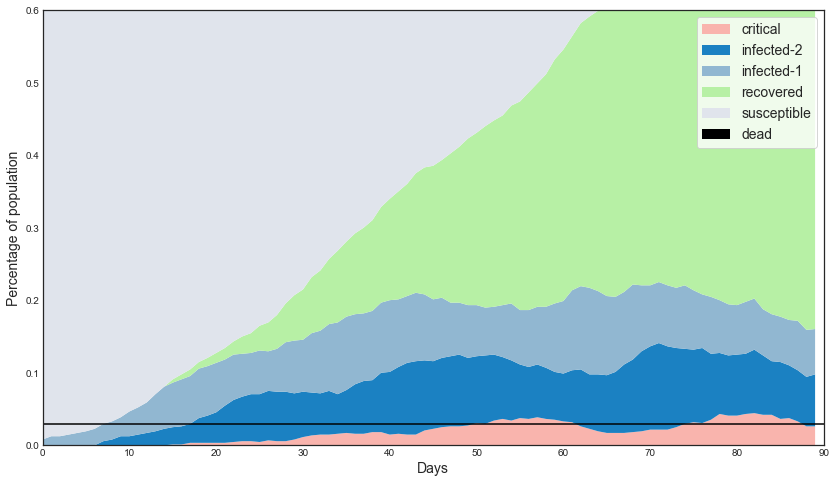

In [81]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(TIME)]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(HEALTH_SYSTEM_CAPACITY, color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Percentage of population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,TIME])
plt.ylim([0, 0.6])

fig.savefig('the_curve.png')

# Timing the model

In [6]:
import time

In [7]:
def simulate(n_agents):
    start_time = time.time()
    environment = EnvironmentNetwork(SEED, number_agents=n_agents, prob_transmit=TRANSMISSION_RATE, 
                                 prob_hospital=PROBABILITY_HOSPITAL, prob_death=PROBABILITY_TO_DIE, 
                                 prob_susceptible=PROBABILITY_SUSCEPTIBLE)
    environment.simulate(SEED, TIME, days_incubation=INCUBATION_DAYS, days_with_symptoms=SYMPTOM_DAYS, 
                     days_critical=CRITICAL_DAYS, relative_hospital_capacity=HEALTH_SYSTEM_CAPACITY, 
                     hospital_overburdened_multiplier=NO_HOSPITAL_MULTIPLIER, high_performance=True, verbose=False)
    
    return time.time() - start_time

In [187]:
#simulate(100000)

# Network creation algorithm:

1. Create Caveman graph
2. Find cliques and associate with neighbourhoods
3. reduce the amount of edges in neighbourhoods depending on population density *(possibly also remove nodes based on population)*
4. create some new links (travel) between neighbourhoods, based on 

(social distancing = reducing more links in neighbourhood networks)

### 1 create caveman graph
With the amount of neighbourhoods from data and initially with max nodes.

In [28]:
# correct for the amount of agents you want
nbd_values = [x[1] for x in NEIGHBOURHOOD_DATA]
nbd_keys = [x[0] for x in NEIGHBOURHOOD_DATA]
population_per_neighbourhood = [x['population'] for x in nbd_values]

In [29]:
correction_factor = sum(population_per_neighbourhood) / NUM_AGENTS
correction_factor

91.14

In [30]:
corrected_populations = [int(x / correction_factor) for x in population_per_neighbourhood]
corrected_populations

[13, 0, 86]

In [31]:
indices_big_neighbourhoods = [i for i, x in enumerate(corrected_populations) if x > 0]
indices_big_neighbourhoods

[0, 2]

In [32]:
corrected_populations_final = [x for i, x in enumerate(corrected_populations) if x > 0]
corrected_populations_final

[13, 86]

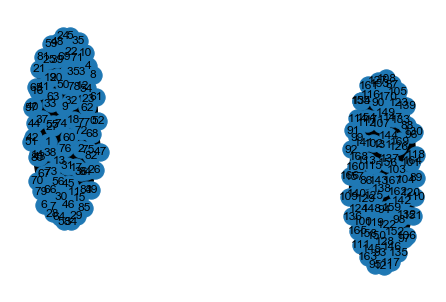

In [33]:
max_citizens = max(corrected_populations_final)
full_graph = nx.caveman_graph(len(corrected_populations_final), max_citizens) # 2 neighbourhoods and both with 6 people 
nx.draw(full_graph, with_labels=True)

### 2 find cliques and associate with neigbhourhoods that are big enough

In [34]:
neighbourhoods = [x for i,x in enumerate(nbd_keys) if i in indices_big_neighbourhoods]

In [35]:
cliques = list(nx.find_cliques(full_graph))

In [36]:
neighbourhood_nodes = {ne: cl for ne, cl in zip(neighbourhoods, cliques)}
#neighbourhood_nodes

### Reduce nodes and edges based on population & density

#### The first step is to reduce the amount of nodes to reflect the size of the neighbourhood

In [37]:
empirical_nodes_per_neighbourhood = {key: value for key, value in zip(neighbourhoods, corrected_populations_final)}

In [38]:
for n in neighbourhoods:
# remove the last nodes from list 
    for nd in neighbourhood_nodes[n][empirical_nodes_per_neighbourhood[n]:]:
        full_graph.remove_node(nd)

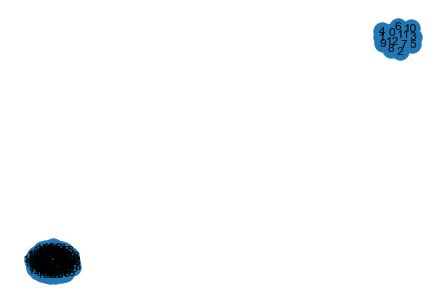

In [39]:
nx.draw(full_graph, with_labels=True)

In [40]:
cliques = list(nx.find_cliques(full_graph))

#### The second step is to reduce the amount of edges to reflect the density of the neighbourhood

In [41]:
def edge_in_cliq(edge, nodes_in_cliq):
    if edge[0] in nodes_in_cliq:
        return True
    else:
        return False

In [42]:
corrected_density_per_neighbourhood = [x['population_KM'] for i, x in enumerate(nbd_values) if i in indices_big_neighbourhoods]

In [43]:
highest_density = 0.5

In [44]:
density_scores = [(float(i)/max(corrected_density_per_neighbourhood)) * highest_density for i in corrected_density_per_neighbourhood]

In [45]:
density_score_per_neighbourhood = {key: value for key, value in zip(neighbourhoods, density_scores)}

In [46]:
edges = list(full_graph.edges)

In [47]:
def edges_to_remove_neighbourhood(all_edges, neighbourhood_density, nbh_nodes):
    neighbourhood_edges = [e for e in all_edges if edge_in_cliq(e, nbh_nodes)]
    sample_size = int(len(neighbourhood_edges) * (1-neighbourhood_density))
    # sample random edges
    chosen_edges = random.sample(neighbourhood_edges, sample_size)
    return chosen_edges

In [48]:
for n in neighbourhoods:
    # actually remove chosen edges
    for e in edges_to_remove_neighbourhood(edges, density_score_per_neighbourhood[n], neighbourhood_nodes[n]):
        full_graph.remove_edge(e[0], e[1])

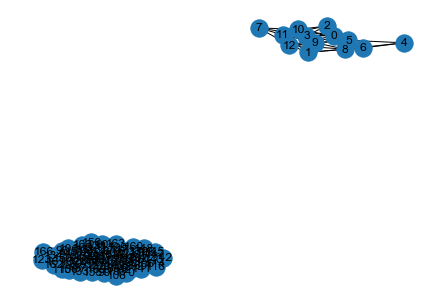

In [49]:
nx.draw(full_graph, with_labels=True)

In [50]:
# update neighbourhood notes to reflect some nodes have been removed
neighbourhood_nodes = {ne: cl for ne, cl in zip(neighbourhoods, cliques)}

In [51]:
#full_graph.edges()

In [52]:
mapping = {key: value for key, value in zip(full_graph.nodes, range(len(full_graph.nodes)))}

In [53]:
for neighb in neighbourhood_nodes:
    neighbourhood_nodes[neighb] = [mapping[x] for x in neighbourhood_nodes[neighb]]

In [54]:
full_graph = nx.relabel_nodes(full_graph, mapping, copy=False)

In [60]:
#full_graph.nodes 

# How to implement travel?

Agents have probability to travel to another neighbourhood

Agents sample x nujmb

Agents will create a edge to the agent that is closest to them 

Store this edge 

In [62]:
random.sample()

TypeError: sample() missing 2 required positional arguments: 'population' and 'k'

In [61]:
for neighbourhood_nodes

{199016089.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 199017021.0: [13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54]}

Find the neighbourhood of an agent, given its index

In [56]:
def what_neighbourhood(index, neighbourhood_nodes):
    for n in neighbourhood_nodes:
        if index in neighbourhood_nodes[n]:
            return n
        else:
            return "Corresponding neighbourhood not found"

In [57]:
# find coordinates 
def what_coordinates(neighbourhood_name, dataset):
    for x in range(len(dataset)):
        if neighbourhood_name in dataset[x]:
            return dataset[x][1]['lon'], dataset[x][1]['lat'],
        else:
            return "Corresponding coordinates not found"


#neighourhood_data[0][1]

### Calculate the distance between two points using geopy

In [70]:
import geopy.distance

In [76]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.geodesic(coords_1, coords_2).km)

279.35290160430094


In [ ]:
for idx, agent in enumerate(self.agents):
    self.network.nodes[idx]['agent'] = agent